In [2]:
import numpy as np
import copy
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, save_nifti
from dipy.segment.mask import median_otsu
from dipy.reconst.dti import TensorModel
from dipy.segment.mask import segment_from_cfa
from dipy.segment.mask import bounding_box
import dipy.reconst.cross_validation as xval
import dipy.reconst.dti as DTI
import dipy.reconst.csdeconv as CSD
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.ndimage.morphology import binary_dilation

C:\Users\XYPB\AppData\Local\Temp\ipykernel_17792\2031616880.py:16: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation


In [2]:
s3sh_fname = 'dataset\sherbrooke_3shell\HARDI193.nii.gz'

data, affine = load_nifti(s3sh_fname)

In [3]:
def norm_data(data):
    min_data = np.min(data, axis=(0,1,2), keepdims=True)
    max_data = np.max(data, axis=(0,1,2), keepdims=True)
    return (data.astype(np.float32) - min_data) / (max_data - min_data)

In [12]:
import PIL.Image as Image

data = norm_data(data)
data = (255*data).astype(np.uint8)
imgs = []
for i in range(data.shape[-2]):
    imgs.append(Image.fromarray(data[:,:,i,40]))

In [16]:
imgs[0].save('s3sh_voxel_40.gif', save_all=True, append_images=imgs[1:], duration=100, loop=0)

In [37]:
data, affine = load_nifti('experiments/hardi150_denoise_230426_211632_baseline/results/hardi150_denoised.nii.gz')
plt.imsave('./tmp/match/ddm2.png', data[:,:,34, 40], cmap='gray')

In [32]:
data, affine = load_nifti('dataset/stanford_hardi/HARDI150_canny.nii.gz')
# data = norm_data(data)
# data = (255 * data).astype(np.uint8)
plt.imsave('./tmp/match/canny.png', data[:,:,34, 40], cmap='gray')

In [31]:
data, affine = load_nifti('experiments/hardi150_denoise_230430_115119_control/results/hardi150_denoised.nii.gz')
# data = norm_data(data)
# data = (255 * data).astype(np.uint8)
plt.imsave('./tmp/match/control.png', data[:,:,34, 40], cmap='gray')

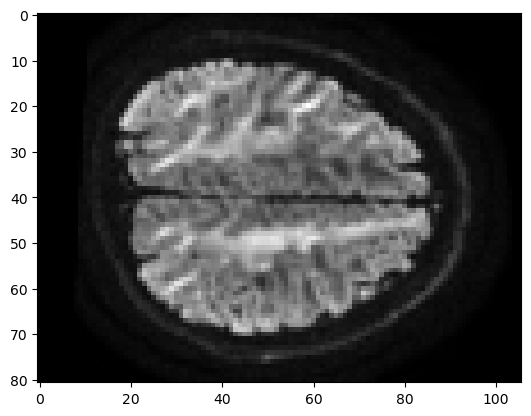

In [26]:
data, affine = load_nifti('experiments\hardi150_p2s\denoised_StanfordHardi_p2s_mlp.nii.gz')
data = data[:,:,:,10:160]
plt.imshow(data[:,:,52, 32], cmap='gray')
plt.imsave('./tmp/vis/52_39_p2s.png', data[:,:,52, 32], cmap='gray')

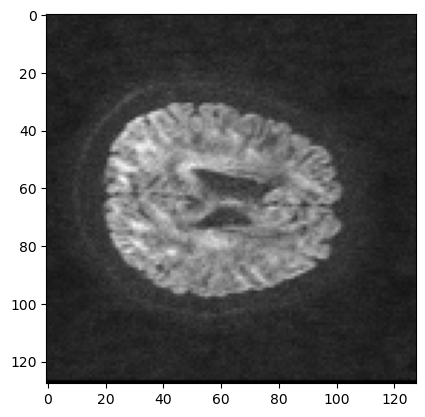

In [22]:
data, affine = load_nifti('experiments\s3sh_p2s\denoised_sherbrooke_3shell_p2s_mlp.nii.gz')
data = data[:,:,:,65:129]
plt.imshow(data[:,:,35, 40], cmap='gray')
plt.imsave('./tmp/vis/35_40_p2s.png', data[:,:,35, 40], cmap='gray')

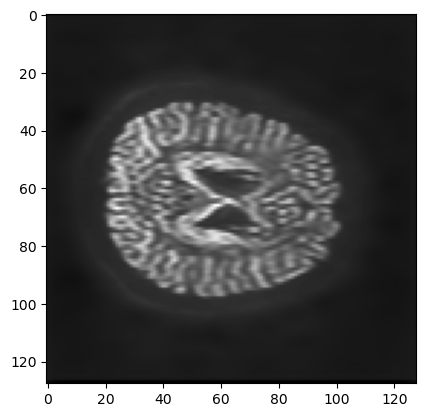

In [23]:
data, affine = load_nifti('experiments/s3sh_denoise_230430_045617_ddim/results/s3sh_denoised.nii.gz')
plt.imshow(data[:,:,35, 40], cmap='gray')
plt.imsave('./tmp/vis/35_40_ddim.png', data[:,:,35, 40], cmap='gray')

In [12]:
data, affine = load_nifti('experiments\hardi150_p2s\denoised_StanfordHardi_p2s_mlp.nii.gz')
plt.imsave('./tmp/vis/38_39_p2s.png', data[:,:,38, 32], cmap='gray')


canny, affine = load_nifti('dataset\stanford_hardi\HARDI150_canny.nii.gz')
voxel_mask = [0] + list(range(10, 160))
canny = canny[..., voxel_mask]
canny = norm_data(canny)

p2s_canny, affine = load_nifti('experiments/hardi150_p2s/denoised_StanfordHardi_p2s_mlp_canny.nii.gz')
voxel_mask = [0] + list(range(10, 160))
p2s_canny = p2s_canny[..., voxel_mask]
p2s_canny = norm_data(p2s_canny)

ddm_canny, affine = load_nifti('experiments/hardi150_denoise_230426_211632_baseline/results/hardi150_denoised_canny.nii.gz')
ddm_canny = np.concatenate((canny[..., [0]], ddm_canny), axis=-1)
ddm_canny = norm_data(ddm_canny)

ddim_canny, affine = load_nifti('experiments/hardi150_denoise_230430_033002_ddim/results/hardi150_denoised_canny.nii.gz')
ddim_canny = np.concatenate((canny[..., [0]], ddim_canny), axis=-1)
ddim_canny = norm_data(ddim_canny)

our_canny, affine = load_nifti('experiments/hardi150_denoise_230430_115119_control/results/hardi150_denoised_canny.nii.gz')
our_canny = np.concatenate((canny[..., [0]], our_canny), axis=-1)
our_canny = norm_data(our_canny)




In [28]:
plt.imsave('./tmp/vis/40_39_canny.png', canny[:,:,40, 32], cmap='gray')
plt.imsave('./tmp/vis/40_39_p2s_canny.png', p2s_canny[:,:,40, 32], cmap='gray')
plt.imsave('./tmp/vis/40_39_ddm2_canny.png', ddm_canny[:,:,40, 32], cmap='gray')
plt.imsave('./tmp/vis/40_39_ddim_canny.png', ddim_canny[:,:,40, 32], cmap='gray')
plt.imsave('./tmp/vis/40_39_control_canny.png', our_canny[:,:,40, 32], cmap='gray')

In [29]:
canny, affine = load_nifti('dataset/sherbrooke_3shell/HARDI193_canny.nii.gz')
voxel_mask = [0] + list(range(65,129))
canny = canny[..., voxel_mask]
canny = norm_data(canny)
print(canny.shape)

p2s_canny, affine = load_nifti('experiments/s3sh_p2s/denoised_sherbrooke_3shell_p2s_mlp_canny.nii.gz')
voxel_mask = [0] + list(range(65,129))
p2s_canny = p2s_canny[..., voxel_mask]
p2s_canny = norm_data(p2s_canny)
print(canny.shape)

ddm_canny, affine = load_nifti('experiments/s3sh_denoise_230426_233927_baseline/results/s3sh_denoised_canny.nii.gz')
ddm_canny = np.concatenate((canny[..., [0]], ddm_canny), axis=-1)
ddm_canny = norm_data(ddm_canny)
print(ddm_canny.shape)

ddim_canny, affine = load_nifti('experiments/s3sh_denoise_230430_045617_ddim/results/s3sh_denoised_canny.nii.gz')
ddim_canny = np.concatenate((canny[..., [0]], ddim_canny), axis=-1)
ddim_canny = norm_data(ddim_canny)
print(ddm_canny.shape)

our_canny, affine = load_nifti('experiments/s3sh_denoise_230430_224918_control/results/s3sh_denoised_canny.nii.gz')
our_canny = np.concatenate((canny[..., [0]], our_canny), axis=-1)
our_canny = norm_data(our_canny)
print(ddm_canny.shape)

(128, 128, 60, 65)
(128, 128, 60, 65)
(128, 128, 60, 65)
(128, 128, 60, 65)
(128, 128, 60, 65)


In [30]:
plt.imsave('./tmp/vis/35_40_canny.png', canny[:,:,35, 40], cmap='gray')
plt.imsave('./tmp/vis/35_40_p2s_canny.png', p2s_canny[:,:,35, 40], cmap='gray')
plt.imsave('./tmp/vis/35_40_ddm2_canny.png', ddm_canny[:,:,35, 40], cmap='gray')
plt.imsave('./tmp/vis/35_40_ddim_canny.png', ddim_canny[:,:,35, 40], cmap='gray')
plt.imsave('./tmp/vis/35_40_control_canny.png', our_canny[:,:,35, 40], cmap='gray')